---
layout: post
title:  "Fuzzy String Matching"
desc: "Removing the hassle of misspelling from a dataset"
long_desc: "In this article we'll utilise Fuzzy String matching in the fuzzywuzzy Python library to clean up and match some free form text input data with a disastrous amount of misspellings!"
date: ###DATE
categories: [tutorial]
tags: [statistics]
loc: ###LOC
permalink: ###LINK 
redirect_from: "/fuzzy"

math: true
---

In [this tweet](https://twitter.com/dataeditor/status/1280278987797942272), Steven Rich pointed out that Philadelphia is spelled at least [57 different ways in the PPP load data](https://pbs.twimg.com/media/EcR28VpXgAUn7jT?format=png&name=orig), and that this represents both a challenge to fix on the back-end, and a perfect example of why you should do as much work on the front-end to get better input.

In this write up, we'll figure out an easy way of fixing up these spelling issues to produce a far better dataset to work on using the python library **FuzzyWuzzy**.

# The Dataset

We'll source [our copy of the PPP dataset from this Kaggle challenge](https://www.kaggle.com/susuwatari/ppp-loan-data-paycheck-protection-program). I've downloaded this into a local folder called `fuzzy_ppp`.



In [74]:
import pandas as pd

df = pd.read_csv("fuzzy_ppp/PPP_data_150k_plus.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 661218 entries, 0 to 661217
Data columns (total 16 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   LoanRange      661218 non-null  object 
 1   BusinessName   661210 non-null  object 
 2   Address        661201 non-null  object 
 3   City           661203 non-null  object 
 4   State          661218 non-null  object 
 5   Zip            661202 non-null  float64
 6   NAICSCode      654435 non-null  float64
 7   BusinessType   659789 non-null  object 
 8   RaceEthnicity  661218 non-null  object 
 9   Gender         661218 non-null  object 
 10  Veteran        661218 non-null  object 
 11  NonProfit      42462 non-null   object 
 12  JobsRetained   620712 non-null  float64
 13  DateApproved   661218 non-null  object 
 14  Lender         661218 non-null  object 
 15  CD             661218 non-null  object 
dtypes: float64(3), object(13)
memory usage: 80.7+ MB


Alright, so we've got a lot of data here. 600k rows, but really the one we care about is the City. *Note: for a non-introductory tutorial, for sure utilise the ZIP and State to get better determination of the actual city*.

For now, lets just see how many unique cities we have inour dataset.

In [75]:
cities = np.sort(df.City.str.replace(",", "").str.strip().unique().astype(str))
print(cities.size, cities)

15652 ['02155' '1026-02-006' '10550' ... 'ZUNI' 'ZWOLLE' 'nan']


Almost sixteen thousand cities. That is a big number. And some interesting cities that appear to be entirely numeric. Perhaps they are postcodes? Here my lack of familiarity with the US system (as an Australian) means I lack a certain domain knowledge here, but let's push on! To simplify things and make output... readable... lets just look at cities starting with `"PH"`:

In [76]:
cities_p = [c for c in cities if c.startswith("PH")]
cities_p

['PHARR',
 'PHEBA',
 'PHELAN',
 'PHELPS',
 'PHENIX',
 'PHENIX CITY',
 'PHEONIX',
 'PHIADELPHIA',
 'PHIALDELPHIA',
 'PHIL CAMPBELL',
 'PHILA',
 'PHILA.',
 'PHILADELKPHIA',
 'PHILADELPHIA',
 'PHILADELPHILA',
 'PHILADELPIA',
 'PHILADEPHIA',
 'PHILDADELPHIA',
 'PHILDELPHIA',
 'PHILIP',
 'PHILIPPI',
 'PHILIPSBURG',
 'PHILIPSTOWN',
 'PHILLIPS',
 'PHILLIPSBURG',
 'PHILLIPSTON',
 'PHILMONT',
 'PHILO',
 'PHILOMATH',
 'PHILPOT',
 'PHIPPSBURG',
 'PHOENICIA',
 'PHOENIX',
 'PHOENIX AZ 85017',
 'PHOENIXA',
 'PHOENIXVILE',
 'PHOENIXVILLE',
 'PHOENX',
 'PHONEIX']

It's not 57 different spellings in our dataset, but oh boy do we have a lot of different ways of writing down Philadelphia. 

Next up, lets get a proper list of cities from [this github repository](https://github.com/kelvins/US-Cities-Database/blob/master/csv/us_cities.csv). Unfortunately, this dataset is not comprehensive, but it will do for us!

In [77]:
actual_cities = pd.read_csv("fuzzy_ppp/us_cities.csv")
actual_cities

,ID,STATE_CODE,STATE_NAME,CITY,COUNTY,LATITUDE,LONGITUDE
0,1,AK,Alaska,Adak,Aleutians West,55.999722,-161.207778
1,2,AK,Alaska,Akiachak,Bethel,60.891854,-161.392330
2,3,AK,Alaska,Akiak,Bethel,60.890632,-161.199325
3,4,AK,Alaska,Akutan,Aleutians East,54.143012,-165.785368
4,5,AK,Alaska,Alakanuk,Wade Hampton,62.746967,-164.602280
...,...,...,...,...,...,...,...
29875,29876,WY,Wyoming,Worland,Washakie,44.013796,-107.956260
29876,29877,WY,Wyoming,Wright,Campbell,43.829349,-105.532327
29877,29878,WY,Wyoming,Wyarno,Sheridan,44.813333,-106.773333
29878,29879,WY,Wyoming,Yellowstone National Park,Park,44.853913,-110.674366


For simplicity lets again look at just cities starting with `"PH"`.

In [78]:
proper_names = np.unique([c.upper() for c in actual_cities.CITY if c.upper().startswith("PH")])
proper_names

array(['PHARR', 'PHEBA', 'PHELAN', 'PHELPS', 'PHENIX', 'PHENIX CITY',
       'PHIL CAMPBELL', 'PHILADELPHIA', 'PHILIP', 'PHILIPP', 'PHILIPPI',
       'PHILIPSBURG', 'PHILLIPS', 'PHILLIPSBURG', 'PHILLIPSPORT',
       'PHILLIPSVILLE', 'PHILMONT', 'PHILO', 'PHILOMATH', 'PHILOMONT',
       'PHILPOT', 'PHIPPSBURG', 'PHLOX', 'PHOENICIA', 'PHOENIX',
       'PHOENIXVILLE', 'PHYLLIS'], dtype='<U13')

Great! So we have a list of input cities, and actual cities. We don't care about those that have the name correct, so lets pull out only things which **don't** match the name of a known city in our dataset.

In [79]:
unknown = [c for c in cities_p if c not in proper_names]
unknown

['PHEONIX',
 'PHIADELPHIA',
 'PHIALDELPHIA',
 'PHILA',
 'PHILA.',
 'PHILADELKPHIA',
 'PHILADELPHILA',
 'PHILADELPIA',
 'PHILADEPHIA',
 'PHILDADELPHIA',
 'PHILDELPHIA',
 'PHILIPSTOWN',
 'PHILLIPSTON',
 'PHOENIX AZ 85017',
 'PHOENIXA',
 'PHOENIXVILE',
 'PHOENX',
 'PHONEIX']

# FuzzyWuzzy

Now time for the good stuff! Lets delve into the fantastic package [`fuzzywuzzy`](https://github.com/seatgeek/fuzzywuzzy). It uses some smart [Levenshtein distance](https://en.wikipedia.org/wiki/Levenshtein_distance) computation to determine how similar two words are. 

So for an example unknown city in the list above, we'll see how similar it is to all the potential cities we could match them to.

In [80]:
from fuzzywuzzy import fuzz

example = inexact[5]
for potential in proper_names:
    print(f"{example} -> {potential} = {fuzz.ratio(example, potential)}")

PHILADELKPHIA -> PHARR = 33
PHILADELKPHIA -> PHEBA = 44
PHILADELKPHIA -> PHELAN = 53
PHILADELKPHIA -> PHELPS = 53
PHILADELKPHIA -> PHENIX = 42
PHILADELKPHIA -> PHENIX CITY = 33
PHILADELKPHIA -> PHIL CAMPBELL = 54
PHILADELKPHIA -> PHILADELPHIA = 96
PHILADELKPHIA -> PHILIP = 53
PHILADELKPHIA -> PHILIPP = 50
PHILADELKPHIA -> PHILIPPI = 57
PHILADELKPHIA -> PHILIPSBURG = 42
PHILADELKPHIA -> PHILLIPS = 57
PHILADELKPHIA -> PHILLIPSBURG = 48
PHILADELKPHIA -> PHILLIPSPORT = 48
PHILADELKPHIA -> PHILLIPSVILLE = 54
PHILADELKPHIA -> PHILMONT = 38
PHILADELKPHIA -> PHILO = 44
PHILADELKPHIA -> PHILOMATH = 55
PHILADELKPHIA -> PHILOMONT = 36
PHILADELKPHIA -> PHILPOT = 50
PHILADELKPHIA -> PHIPPSBURG = 35
PHILADELKPHIA -> PHLOX = 33
PHILADELKPHIA -> PHOENICIA = 45
PHILADELKPHIA -> PHOENIX = 40
PHILADELKPHIA -> PHOENIXVILLE = 40
PHILADELKPHIA -> PHYLLIS = 50


We can see that the match with the highest similarity is, of course, `PHILADELPHIA`. So what if we just want to find the best match, instead of printing them all out of it, that's very easy to do!

In [81]:
from fuzzywuzzy import process

best_match = process.extractOne(example, proper_names)
print(best_match)

('PHILADELPHIA', 96)


If we want more than one, also easy to do, let's pick a different work and get the top three matches:

In [82]:
example2 = inexact[0]
matches = process.extract(example2, proper_names, limit=3)
print(matches)

[('PHENIX', 92), ('PHOENIX', 86), ('PHENIX CITY', 79)]


How could we improve this? Firstly, we are ignoring the super useful information of the state and the PIN, which we should also be using to inform our decision.

Secondly, at the moment all cities are weighted equally. But larger cities should have more entries, so their prior probability should be higher, and we should introduce a weighting based on the city population. For example, Phoenix has a population around fifty times larger than Phenix, so if the two weightings were around the same, it would be statistically far more likely that the intended entry was Phoenix.

So lets go through now and extract the best match for every city in our inexact list.

In [83]:
for c in inexact:
    print(f"{c} -> {process.extractOne(c, proper_names)[0]}")

PHEONIX -> PHENIX
PHIADELPHIA -> PHILADELPHIA
PHIALDELPHIA -> PHILADELPHIA
PHILA -> PHILADELPHIA
PHILA. -> PHILADELPHIA
PHILADELKPHIA -> PHILADELPHIA
PHILADELPHILA -> PHILADELPHIA
PHILADELPIA -> PHILADELPHIA
PHILADEPHIA -> PHILADELPHIA
PHILDADELPHIA -> PHILADELPHIA
PHILDELPHIA -> PHILADELPHIA
PHILIPSTOWN -> PHILIP
PHILLIPSTON -> PHILLIPS
PHOENIX AZ 85017 -> PHOENIX
PHOENIXA -> PHOENIX
PHOENIXVILE -> PHOENIXVILLE
PHOENX -> PHOENIX
PHONEIX -> PHOENIX


An obvious issue is that our dataset of US cities is not complete. It turns out, there is a tiny town called Philipstown in Putnam County, New York, but its not in our list, so it gets turns into other cities. Apart from that, this is pretty good! If we wanted to do this in a dataframe, we could use `df.map(lambda x: process.extractOne(x, proper_names)[0])` on anything that doesn't match to extract a new series.

Now, this is all great, but theres plenty more we can do with the `fuzzywuzzy` library.

# Token Matching

Let's have a different example: acronyms.

In [84]:
a = "National Aeronautics and Space Administration (NASA)"
b = "NASA"

We know these refer to the same things, but if we tried a simple ratio similarity test we wouldn't look too good:

In [85]:
print(fuzz.ratio(a, b))

14


Of course, this compares the entire strings. We can ask for the partial ratio which will help us out a lot:

In [86]:
print(fuzz.partial_ratio(a, b))

75


But we can go more complicated:

In [87]:
a = "Machine Learning vs Artifical Intelligence"
b = "Artifical Intelligence vs Machine Learning"

print(fuzz.ratio(a, b), fuzz.partial_ratio(a, b))

52 52


Obviously swapping the order has confused things. So lets tokenise!

In [88]:
print(fuzz.token_sort_ratio(a, b))

100


Oh yeah, thats what we want. Its broken the string down into tokens, sorted them, then taken the ratio so that we don't care about order. **But wait, there's more!**

In [89]:
a = "Machine Learning vs Artifical Intelligence"
b = "The Incredible and Often Semantic difference between Artifical Intelligence and Machine Learning"

print(fuzz.token_sort_ratio(a, b), fuzz.token_set_ratio(a, b))

59 96


The sheer size difference between the two strings means that our `token_sort_ratio` is now not giving good results. Instead, we can use `token_set_ratio` which breaks both strings into tokens, and then takes into account the intersection of those two sets better. 

As a final note, computing the distance (and thus ratios) between strings is a slow process. Running this for millions of records at a time will take a *very* long time, so this is a great process suited for cleaning data upon ingestion, such that the task is distributed over time and not run in bulk.

I should point out that `process.extract` (and similar methods) allow you to specify the scoring algorithm used. By default, its `fuzz.WRatio`, which is a smart algorithm which runs `ratio`, `partial_ratio` and the tokenised versions depending on the size difference and matching between the strings.

# Summary

`fuzzywuzzy` is a great tool for matching strings based on their Levenshtein distance. The ones we touched on are:

* `fuzz.ratio`: Distance between two strings
* `fuzz.partial_ratio`: Takes partial matching into account
* `fuzz.token_sort_ratio`: Tokenises your string
* `fuzz.token_set_ratio`: Takes the intersection of tokens into account better
* `fuzz.WRatio`: Smart weighted ratio of many methods
* `process.extract`: Uses (by default) `WRatio` to get match again a list of input string
* `process.extractOne`: Returns only the best match from a list of input strings.

But there are plenty more, so go check out the library!

In [104]:
x = df.City.str.replace(",", "").str.strip().sample(10000)
x = x[~x.isnull()].value_counts().reset_index()
x.columns = ["Word", "Weight"]
x = x[["Weight", "Word"]]
x = x.append({"Weight": 400, "Word": "Fuzzy Wuzzy"}, ignore_index=True)
x["Weight"] = 70 + x.Weight
x.to_csv("fuzzy_ppp/cities.csv", index=False)
x

,Weight,Word
0,270,NEW YORK
1,186,HOUSTON
2,165,CHICAGO
3,162,LOS ANGELES
4,137,MIAMI
...,...,...
3177,71,SPEONK
3178,71,BARRINGTON
3179,71,EAST PEORIA
3180,71,ENDICOTT


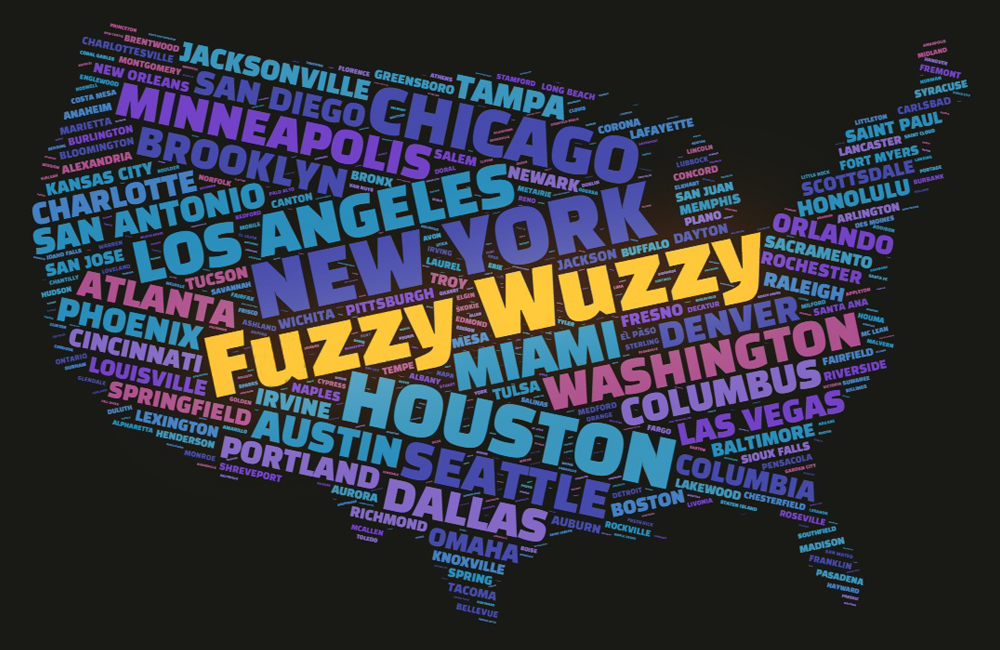

In [106]:
from IPython.display import Image
Image("fuzzy_ppp/cover.png")

!!!main remove_main